# Part II : Logistic Regression Using Gradient Descent

### Dataset : Penguins Dataset

1. Import Libraries

In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

In [18]:
# Read preprocessed penguins dataset
penguins_data = pd.read_csv('./preprocessed/penguins_preprocessed.csv')


In [19]:
penguins_data

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_adelie,species_chinstrap,species_gentoo,island_biscoe,island_dream,island_na,island_torgersen,gender_female,gender_male
0,39.1,18.7,181.0,3750.0,1,0,0,0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,1,0,0,0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,1,0,0,0,0,0,1,1,0
3,36.7,19.3,193.0,3450.0,1,0,0,0,0,0,1,1,0
4,39.3,20.6,190.0,3650.0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,55.8,19.8,207.0,4000.0,0,1,0,0,1,0,0,0,1
312,43.5,18.1,202.0,3400.0,0,1,0,0,1,0,0,1,0
313,49.6,18.2,193.0,3775.0,0,1,0,0,1,0,0,0,1
314,50.8,19.0,210.0,4100.0,0,1,0,0,1,0,0,0,1


2. Choosing target Y and split the dataset

- Here in this case I choose penguin gender (male or female) as the target variable Y. So we need to predict whether a penguin is male or female - a Classification problem.
- I can just drop the 'gender_female' column for simplicity. The model output will be whether the input penguin is Male or Not
- In other words, gender(penguin) == Male, return True

In [20]:
copy_final = penguins_data.drop('gender_female', axis=1)

# Creating training and test set using 80% train and 20% test ratio
training_set = copy_final.sample(frac=0.8, random_state=128) 
test_set = copy_final.drop(training_set.index)

print("train data shapes: ", training_set.shape)
print("test data shapes: ", test_set.shape)

train data shapes:  (253, 12)
test data shapes:  (63, 12)


3. Normalize

In [21]:
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())

In [22]:
# Normalize training set
for column in ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']:
    training_set[column] = normalize(training_set[column])

training_set[:5]

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_adelie,species_chinstrap,species_gentoo,island_biscoe,island_dream,island_na,island_torgersen,gender_male
95,0.080595,0.035915,0.457627,0.291667,1,0,0,1,0,0,0,0
21,0.071916,0.048178,0.000000,0.125000,1,0,0,1,0,0,0,0
308,0.245505,0.056062,0.576271,0.347222,0,1,0,0,1,0,0,1
69,0.123993,0.052558,0.389831,0.361111,1,0,0,0,0,0,1,1
5,0.084315,0.041170,0.152542,0.256944,1,0,0,0,0,0,1,0


In [23]:
# Normalize test set
for column in ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']:
    test_set[column] = normalize(test_set[column])

test_set[:5]

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_adelie,species_chinstrap,species_gentoo,island_biscoe,island_dream,island_na,island_torgersen,gender_male
0,0.055982,0.833333,0.057692,0.274194,1,0,0,0,0,0,1,1
1,0.060849,0.616667,0.153846,0.290323,1,0,0,0,0,0,1,0
10,0.025557,0.683333,0.134615,0.258065,1,0,0,0,0,0,1,0
16,0.045029,0.733333,0.134615,0.338710,1,0,0,1,0,0,0,1
17,0.052331,0.583333,0.038462,0.290323,1,0,0,1,0,0,0,1


In [24]:
x_train = training_set.drop('gender_male', axis=1)
y_train = training_set['gender_male']

x_test = test_set.drop('gender_male', axis=1)
y_test = test_set['gender_male']

print("train data shapes: ", x_train.shape, y_train.shape)
print("test data shapes: ", x_test.shape, y_test.shape)

train data shapes:  (253, 11) (253,)
test data shapes:  (63, 11) (63,)


4. Logistic Regression Implementation

In [25]:
class LogitRegression():
    def __init__(self, learning_rate, iterations):
        self.alpha = learning_rate
        self.iterations = iterations
        self.weights = None
        self.n = None
        self.loss = []
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def cost(self, y, y_pred):
        jw = (1/self.n)*np.sum(-y*np.log(y_pred) - (1-y)*np.log(1-y_pred))
        return jw

    def gradient_descent(self, X, y):
        y_pred = self.sigmoid(np.dot(X, self.weights))
        delta = y_pred - y
        dw = np.dot(X.T, delta)/self.n
        self.weights -= self.alpha*dw #Update Weights


    def fit(self, X, y, w):
        if X.shape[0] != y.shape[0]:
            print("X and Y are not of same dimentions")
            return 

        self.n = X.shape[0]

        # Initialize weights(W_0 for bias term)
        self.weights = w
        self.weights[0] = 1 #for bias term

        # Add ones to starting row for bias term
        X = np.column_stack((np.ones(X.shape[0]), X))

        for i in range(self.iterations):
            # Call Gradient Descent
            self.gradient_descent(X, y)

            y_pred = self.sigmoid(np.dot(X, self.weights))
            loss = self.cost(y, y_pred)
            if i % 1000 == 0:
                print(f"Loss at iteration {i}: {loss}")
            self.loss.append(loss)

        pickle.dump(self.weights, open("log_reg_weights.p", "wb" ))

    def predict(self, X):
        X = np.insert(X, 0, 1)
        try:
            wt = pickle.load(open("log_reg_weights.p", "rb" ) )
        except FileNotFoundError:
            wt = self.weights
        y_pred = self.sigmoid(np.dot(X, wt))
        if y_pred >= 0.5:
            return 1
        else:
            return 0

In [26]:
penguin_model = LogitRegression(0.001, 500000)

In [27]:
# Initialize random weights
intial_w = np.random.rand(1 + x_train.shape[1]) 

In [28]:
intial_w2 = np.ones(1 + x_train.shape[1])

In [29]:
intial_w3 = np.zeros(1 + x_train.shape[1])

In [30]:
penguin_model.fit(x_train, y_train, intial_w)

Loss at iteration 0: 1.3336261383341002
Loss at iteration 1000: 1.0312253282908603
Loss at iteration 2000: 0.8476627041202122
Loss at iteration 3000: 0.75774783945615
Loss at iteration 4000: 0.7190195715460993
Loss at iteration 5000: 0.702179210524151
Loss at iteration 6000: 0.6936875569966731
Loss at iteration 7000: 0.6883279653317756
Loss at iteration 8000: 0.6842173695421299
Loss at iteration 9000: 0.6806763933386757
Loss at iteration 10000: 0.6774470335796253
Loss at iteration 11000: 0.6744201679257998
Loss at iteration 12000: 0.6715418270137671
Loss at iteration 13000: 0.6687805182309544
Loss at iteration 14000: 0.6661153271731054
Loss at iteration 15000: 0.6635311957707294
Loss at iteration 16000: 0.6610167798809218
Loss at iteration 17000: 0.6585633093024262
Loss at iteration 18000: 0.656163889190952
Loss at iteration 19000: 0.6538130285531435
Loss at iteration 20000: 0.651506303805598
Loss at iteration 21000: 0.6492401114453774
Loss at iteration 22000: 0.6470114832272498
Loss a

5. Test accuracy with test set

In [31]:
n_correct = 0
x_test_copy = x_test.values # Converting to np arrays
y_test_copy = y_test.values

for i in range(y_test_copy.shape[0]):
    y = penguin_model.predict(x_test_copy[i])
    if y == y_test_copy[i]:
        n_correct += 1

accuracy = n_correct/y_test_copy.shape[0]

print(f"Accuracy is {accuracy*100}%")

Accuracy is 69.84126984126983%


5. Print Loss Graph

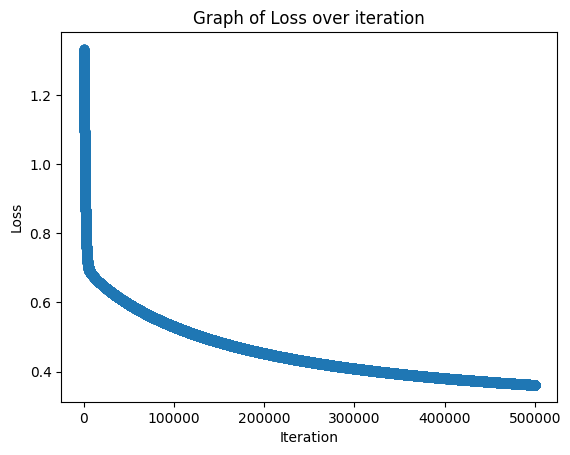

In [32]:
plt.scatter(range(len(penguin_model.loss)), penguin_model.loss)
plt.title("Graph of Loss over iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### REFERENCES

https://wiki.python.org/moin/UsingPickle